In [1]:
#First let's import some packages
import xarray as xr
import numpy as np
from xgcm.grid import Grid
import xrft
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
from pyresample.bilinear import NumpyBilinearResampler
from pyresample import geometry
from matplotlib.colors import LogNorm

In [2]:
unfiltered_vels = xr.open_zarr('/swot/SUM03/spencer/agulhas_vels/unfiltered_vels.zarr')
filtered_vels = xr.open_zarr('/swot/SUM03/spencer/agulhas_vels/filtered_vels.zarr')
eul_unfiltered_vels = xr.open_zarr('/swot/SUM03/spencer/agulhas_vels/eul_unfiltered_vels.zarr')
eul_filtered_vels = xr.open_zarr('/swot/SUM03/spencer/agulhas_vels/eul_filtered_vels.zarr')
RAZ =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RAZ.data', dtype='>f4').reshape(2160,2160)
DXC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXC.data', dtype='>f4').reshape(2160,2160)
DYC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYC.data', dtype='>f4').reshape(2160,2160)
XC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/XC.data', dtype='>f4').reshape(2160,2160)
YC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/YC.data', dtype='>f4').reshape(2160,2160)
XG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/XG.data', dtype='>f4').reshape(2160,2160)
YG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/YG.data', dtype='>f4').reshape(2160,2160)

In [3]:
ds = eul_filtered_vels
grid = Grid(ds,coords={'X': {'center': 'i', 'left': 'i_g'},'Y': {'center': 'j', 'left': 'j_g'}})
ds = ds.assign_coords({"raZ":(["j_g","i_g"],RAZ)})
ds = ds.assign_coords({"dxC":(["j","i_g"],DXC)})
ds = ds.assign_coords({"dyC":(["j_g","i"],DYC)})

In [4]:
eul_unf_utransport = eul_unfiltered_vels.u*ds.dyG*ds.hFacW*ds.drF
eul_unf_vtransport = eul_unfiltered_vels.v*ds.dxG*ds.hFacS*ds.drF

unf_utransport = unfiltered_vels.u*ds.dyG*ds.hFacW*ds.drF
unf_vtransport = unfiltered_vels.v*ds.dxG*ds.hFacS*ds.drF

eul_utransport = eul_filtered_vels.u*ds.dyG*ds.hFacW*ds.drF
eul_vtransport = eul_filtered_vels.v*ds.dxG*ds.hFacS*ds.drF

filt_utransport = filtered_vels.u*ds.dyG*ds.hFacW*ds.drF
filt_vtransport = filtered_vels.v*ds.dxG*ds.hFacS*ds.drF

In [5]:
div_unf = (grid.diff(unf_utransport, 'X') + grid.diff(unf_vtransport, 'Y')) / ds.raC
div_eul = (grid.diff(eul_utransport, 'X') + grid.diff(eul_vtransport, 'Y')) / ds.raC
div_filt = (grid.diff(filt_utransport, 'X') + grid.diff(filt_vtransport, 'Y')) / ds.raC

In [7]:
div_unf

<xarray.DataArray (time: 49, i: 2160, j: 2160)>
dask.array<truediv, shape=(49, 2160, 2160), dtype=float64, chunksize=(1, 179, 179), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 3600 7200 10800 ... 162000 165600 169200 172800
  * i        (i) int64 1080 1081 1082 1083 1084 ... 3235 3236 3237 3238 3239
  * j        (j) float64 0.0 1.0 2.0 3.0 ... 2.157e+03 2.158e+03 2.159e+03
    drF      float32 ...
    face     int64 ...
    hFacC    (j, i) float32 dask.array<chunksize=(180, 180), meta=np.ndarray>
    k        int64 ...
    raC      (j, i) float32 dask.array<chunksize=(180, 180), meta=np.ndarray>

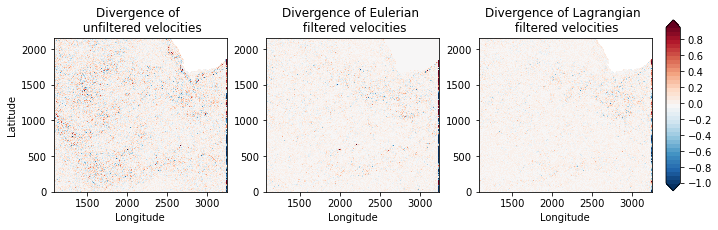

In [10]:
plt.figure(figsize=(10,3.3))
plt.subplot(131)
(div_unf.isel(time=0)*10**4).plot.pcolormesh(x='i',y='j',levels=np.arange(-1,1,0.05),rasterized=True,add_colorbar=False,cmap='RdBu_r')
plt.xlim(15,19)
plt.ylim(-43,-39)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Divergence of \n unfiltered velocities')

plt.subplot(132)
(div_eul.isel(time=0)*10**4).plot.pcolormesh(x='i',y='j',levels=np.arange(-1,1,0.05),rasterized=True,add_colorbar=False,cmap='RdBu_r')
plt.xlim(15,19)
plt.ylim(-43,-39)
plt.xlabel('Longitude')
plt.ylabel('')
plt.title('Divergence of Eulerian \n filtered velocities')

plt.subplot(133)
cs=(div_filt.isel(time=0)*10**4).plot.pcolormesh(x='i',y='j',levels=np.arange(-1,1,0.05),rasterized=True,add_colorbar=False,cmap='RdBu_r')
plt.xlim(15,19)
plt.ylim(-43,-39)
plt.xlabel('Longitude')
plt.ylabel('')
plt.title('Divergence of Lagrangian \n filtered velocities')

fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax,extend='both')
fig = plt.gcf()
fig.savefig("divergence_zoom.png")

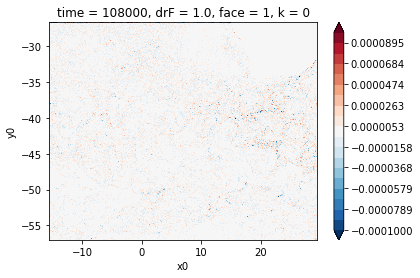

In [104]:
div_eul.isel(time=30).plot(x='x0',y='y0',levels=np.linspace(-0.0001,0.0001,20))
#plt.xlim(15,23)
#plt.ylim(-43,-35)

In [13]:
zeta_unf = (-grid.diff(unfiltered_vels.u * ds.dxC, 'Y') + grid.diff(unfiltered_vels.v * ds.dyC, 'X'))/ds.raZ
zeta_eul = (-grid.diff(eul_filtered_vels.u * ds.dxC, 'Y') + grid.diff(eul_filtered_vels.v * ds.dyC, 'X'))/ds.raZ
zeta_filt = (-grid.diff(filtered_vels.u * ds.dxC, 'Y') + grid.diff(filtered_vels.v * ds.dyC, 'X'))/ds.raZ

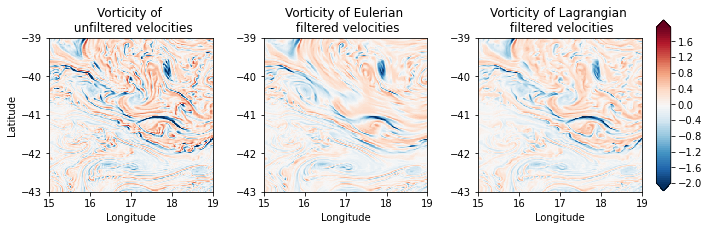

In [113]:
plt.figure(figsize=(10,3.3))
plt.subplot(131)
(zeta_unf.isel(time=0)*10**4).plot.pcolormesh(x='x0',y='y0',levels=np.arange(-2,2,0.05),rasterized=True,add_colorbar=False,cmap='RdBu_r')
plt.xlim(15,19)
plt.ylim(-43,-39)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Vorticity of \n unfiltered velocities')

plt.subplot(132)
(zeta_eul.isel(time=0)*10**4).plot.pcolormesh(x='x0',y='y0',levels=np.arange(-2,2,0.05),rasterized=True,add_colorbar=False,cmap='RdBu_r')
plt.xlim(15,19)
plt.ylim(-43,-39)
plt.xlabel('Longitude')
plt.ylabel('')
plt.title('Vorticity of Eulerian \n filtered velocities')

plt.subplot(133)
cs=(zeta_filt.isel(time=0)*10**4).plot.pcolormesh(x='x0',y='y0',levels=np.arange(-2,2,0.05),rasterized=True,add_colorbar=False,cmap='RdBu_r')
plt.xlim(15,19)
plt.ylim(-43,-39)
plt.xlabel('Longitude')
plt.ylabel('')
plt.title('Vorticity of Lagrangian \n filtered velocities')

fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax,extend='both')
fig = plt.gcf()
fig.savefig("vorticity_zoom.png")

In [14]:
with ProgressBar():
    div_un = xrft.power_spectrum(div_unf.chunk({'time':-1}),dim=['time'], window=True,window_correction=True
                                   ).compute()#, detrend='linear'
    vort_un = xrft.power_spectrum(zeta_unf.chunk({'time':-1}),dim=['time'], window=True,window_correction=True
                                   ).compute()#, detrend='linear'

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed |  4min  1.6s


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed |  3min 36.0s


In [15]:
with ProgressBar():
    div_e = xrft.power_spectrum(div_eul.chunk({'time':-1}),dim=['time'], window=True,window_correction=True
                                   ).compute()#, detrend='linear'
    vort_e = xrft.power_spectrum(zeta_eul.chunk({'time':-1}),dim=['time'], window=True,window_correction=True
                                   ).compute()#, detrend='linear'

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed | 10.6s


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed |  8.3s


In [16]:
with ProgressBar():
    div_f = xrft.power_spectrum(div_filt.chunk({'time':-1}),dim=['time'], window=True,window_correction=True
                                   ).compute()#, detrend='linear'
    vort_f = xrft.power_spectrum(zeta_filt.chunk({'time':-1}),dim=['time'], window=True,window_correction=True
                                   ).compute()#, detrend='linear'

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed |  3min 40.7s


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


[########################################] | 100% Completed |  3min 21.3s


In [17]:
spec0 = int((div_un['freq_time'].size-1)/2)

fm = 2*2*np.pi/24/3600*np.sin(-43*np.pi/180)

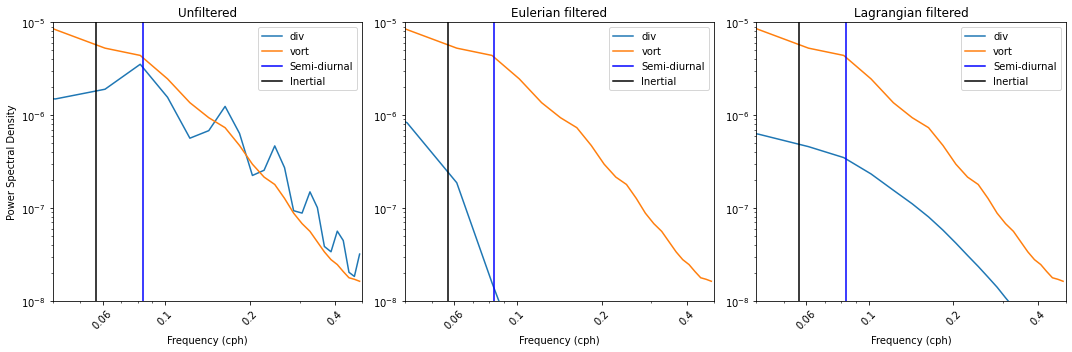

In [18]:
xticks_s = [6*10**-2,10**-1,2*10**-1,4*10**-1]

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.plot(div_un.freq_time[spec0:]*3600,div_un.mean(['i','j'])[spec0:],label='div')
plt.plot(vort_un.freq_time[spec0:]*3600,vort_un.mean(['i_g','j_g'])[spec0:],label='vort')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial',color='k')
plt.ylabel('Power Spectral Density')


plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Unfiltered')
plt.ylim(10**-8,10**-5)
plt.xlim(0.04,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')

plt.subplot(132)
plt.plot(div_e.freq_time[spec0:]*3600,div_e.mean(['i','j'])[spec0:],label='div')
plt.plot(vort_e.freq_time[spec0:]*3600,vort_un.mean(['i_g','j_g'])[spec0:],label='vort')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Eulerian filtered')
plt.ylim(10**-8,10**-5)
plt.xlim(0.04,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')


plt.subplot(133)
plt.plot(div_f.freq_time[spec0:]*3600,div_f.mean(['i','j'])[spec0:],label='div')
plt.plot(vort_f.freq_time[spec0:]*3600,vort_un.mean(['i_g','j_g'])[spec0:],label='vort')
#plt.axvline([1/86400*3600],label='Diurnal',color='r')
plt.axvline([2/86400*3600],label='Semi-diurnal',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
#left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
#bottom, height = 0, 10**8
#ax = plt.gca()
#p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
#ax.add_patch(p)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Lagrangian filtered')
plt.ylim(10**-8,10**-5)
plt.xlim(0.04,0.5)
plt.xticks(xticks_s,xticks_s, rotation=45)
plt.xlabel('Frequency (cph)')

plt.tight_layout()
fig=plt.gcf()
fig.savefig('div_filt_unfilt.png')

In [19]:
div_unf = div_unf.assign_coords(x0=("i", XC[0,:])).swap_dims({"i": "x0"})
div_unf = div_unf.assign_coords(y0=("j", YC[:,0])).swap_dims({"j": "y0"})
div_eul = div_eul.assign_coords(x0=("i", XC[0,:])).swap_dims({"i": "x0"})
div_eul = div_eul.assign_coords(y0=("j", YC[:,0])).swap_dims({"j": "y0"})
div_filt = div_filt.assign_coords(x0=("i", XC[0,:])).swap_dims({"i": "x0"})
div_filt = div_filt.assign_coords(y0=("j", YC[:,0])).swap_dims({"j": "y0"})

In [20]:
zeta_unf = zeta_unf.assign_coords(x0=("i_g", XG[0,:])).swap_dims({"i_g": "x0"})
zeta_unf = zeta_unf.assign_coords(y0=("j_g", YG[:,0])).swap_dims({"j_g": "y0"})
zeta_eul = zeta_eul.assign_coords(x0=("i_g", XG[0,:])).swap_dims({"i_g": "x0"})
zeta_eul = zeta_eul.assign_coords(y0=("j_g", YG[:,0])).swap_dims({"j_g": "y0"})
zeta_filt = zeta_filt.assign_coords(x0=("i_g", XG[0,:])).swap_dims({"i_g": "x0"})
zeta_filt = zeta_filt.assign_coords(y0=("j_g", YG[:,0])).swap_dims({"j_g": "y0"})

In [21]:
lons, lats = np.meshgrid(div_unf.x0.values, div_unf.y0.values)
lonsg, latsg = np.meshgrid(zeta_unf.x0.values, zeta_unf.y0.values)

In [22]:
def target_area_def(ds_patch,variable_name):
    """Get a pyresample area_def for a given patch."""
    center_point = ds_patch.isel(x0=ds_patch.x0.size//2, y0=ds_patch.y0.size//2)
    center_lon, center_lat = center_point.x0.values.item(), center_point.y0.values.item()
    area_id = 'local_grid'
    description = 'Local Lambert Equal Area Grid'
    proj_id = 'local_grid'
    proj_dict = {'proj': 'laea', 'lat_0': center_lat, 'lon_0': center_lon, 'units': 'm'} #  'a': 6371228.0,

    # 1 km resolution
    width = 512#2160
    height = 512#2160

    # 512 x 512 km
    area_extent = (-270000., -270000., 270000., 270000.)
    area_def = geometry.AreaDefinition(area_id, description, proj_id, proj_dict,
                                       width, height, area_extent)
    return area_def



def resample_transposed(data, resampler):
    return np.transpose(resampler.resample(data), (2, 1, 0))

def ufunc_resample(data,lons,lats):
    target_def = target_area_def(data.isel(time=0),'U')
    source_def = geometry.SwathDefinition(lons=lons, lats=lats)
    resampler = NumpyBilinearResampler(source_def, target_def, 30e3)
    resampled = xr.apply_ufunc(resample_transposed,data,resampler,input_core_dims=[['x0','y0'],['x0','y0']],output_core_dims=[['y1','x1']])
    return resampled

In [23]:
div_un_resampled = ufunc_resample(div_unf.load(),lons,lats)
div_eul_resampled = ufunc_resample(div_eul.load(),lons,lats)
div_filt_resampled = ufunc_resample(div_filt.load(),lons,lats)

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = se

In [24]:
zeta_un_resampled = ufunc_resample(zeta_unf.load(),lonsg,latsg)
zeta_eul_resampled = ufunc_resample(zeta_eul.load(),lonsg,latsg)
zeta_filt_resampled = ufunc_resample(zeta_filt.load(),lonsg,latsg)

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = se

In [41]:
with ProgressBar():
    div_un_ps = xrft.power_spectrum(div_un_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    div_eul_ps = xrft.power_spectrum(div_eul_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    div_filt_ps = xrft.power_spectrum(div_filt_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    div_wav_ps = xrft.power_spectrum(div_un_resampled-div_filt_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


In [42]:
with ProgressBar():
    zeta_un_ps = xrft.power_spectrum(zeta_un_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    zeta_eul_ps = xrft.power_spectrum(zeta_eul_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    zeta_filt_ps = xrft.power_spectrum(zeta_filt_resampled, dim=['x1','y1','time'],window=True,window_correction=True).compute()

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


In [43]:
# Add the isotropic calculation (k,l) -> (k_r) (azimuthally average)
def azimuthal_avg(k, l, f, N, nfactor):
    """
    Takes the azimuthal average of a given field.
    """
    k = k.values; l = l.values
    kk, ll = np.meshgrid(k, l)
    K = np.sqrt(kk**2 + ll**2)
    nbins = int(N/nfactor)
    if k.max() > l.max():
        ki = np.linspace(0., l.max(), nbins)
    else:
        ki = np.linspace(0., k.max(), nbins)

    kidx = np.digitize(np.ravel(K), ki)
    area = np.bincount(kidx)

    kr = np.bincount(kidx, weights=K.ravel()) / area

    if f.ndim == 2:
        iso_f = np.ma.masked_invalid(np.bincount(kidx,
                                    weights=f.data.ravel())
                                    / area) * kr
    else:
        raise ValueError('The data has too many or few dimensions. '
                        'The input should only have the two dimensions '
                        'to take the azimuthal averaging over.')

    return kr, iso_f

def iso_spec_over_depth(ds):
    
    Zlen = len(ds.Z)
    klen = len(ds.freq_XC)
    omegalen = len(ds.freq_time)
    
    nfactor = 4. 
    ds_iso = np.zeros([omegalen , Zlen, int(klen/nfactor+1)])

    for j in range(0,omegalen):
        for i in range(0,Zlen):
            kr, ds_iso[j,i,:] = azimuthal_avg(ds.freq_XC, ds.freq_YC, ds.isel(Z=i, freq_time=j), 
                            len(ds.freq_XC), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'freq_time':ds.freq_time.values, 'Z': ds.Z.values, 'kr':kr }, 
                             dims=['freq_time','Z', 'kr'])
    
    return ds_iso_xr

def iso_spec(ds):
    
    #Zlen = len(ds.Z)
    klen = len(ds.freq_x1)
    omegalen = len(ds.freq_time)
    
    nfactor = 4. 
    ds_iso = np.zeros([omegalen ,  int(klen/nfactor+1)])

    for j in range(0,omegalen):
            kr, ds_iso[j,:] = azimuthal_avg(ds.freq_x1, ds.freq_y1, ds.isel(freq_time=j), 
                            len(ds.freq_x1), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'freq_time':ds.freq_time.values, 'kr':kr }, 
                             dims=['freq_time','kr'])
    
    return ds_iso_xr

In [44]:
ps_iso_unfilt = iso_spec(div_un_ps)
ps_iso_eul = iso_spec(div_eul_ps)
ps_iso = iso_spec(div_filt_ps)
ps_iso_wav = iso_spec(div_wav_ps)

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide


In [45]:
ps_iso_zunfilt = iso_spec(zeta_un_ps)
ps_iso_zeul = iso_spec(zeta_eul_ps)
ps_ziso = iso_spec(zeta_filt_ps)

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide


/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:9: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:28: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:47: UserWarning: Log scale: values of z <= 0 have been masked


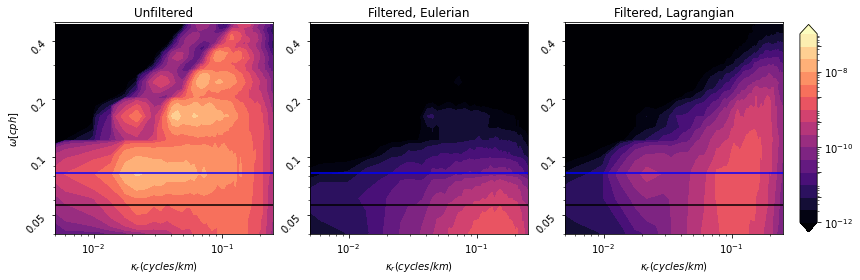

In [30]:
yticks_s = [5*10**-2,10**-1,2*10**-1,4*10**-1]

plt.figure(figsize=(12,4))
omega = ps_iso.freq_time*3600
kr    = ps_iso.kr
lev_exp = np.linspace(-12,-7,16)
lev = np.power(10, lev_exp)
plt.subplot(131)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_unfilt,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

#for i in range(0,6):
#    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
plt.title('Unfiltered')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(132)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_eul,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

#for i in range(0,6):
#    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
#plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
plt.title('Filtered, Eulerian')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(133)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

#for i in range(0,6):
#    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
#plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
plt.title('Filtered, Lagrangian')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)



fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax)


fig.savefig('wavenumber_freq_div.png')

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:6: UserWarning: Log scale: values of z <= 0 have been masked


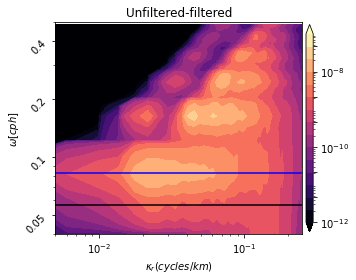

In [46]:
plt.figure(figsize=(5,4))
omega = ps_iso.freq_time*3600
kr    = ps_iso.kr
lev_exp = np.linspace(-12,-7,16)
lev = np.power(10, lev_exp)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_wav,lev,norm=LogNorm(), cmap='magma',extend='both')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
plt.title('Unfiltered-filtered')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)
plt.tight_layout()
fig=plt.gcf()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.86, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax)
fig.savefig('wavenumber_freq_div_wav.png')

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:6: UserWarning: Log scale: values of z <= 0 have been masked


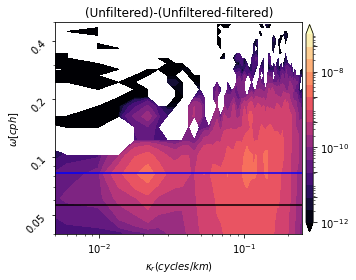

In [49]:
plt.figure(figsize=(5,4))
omega = ps_iso.freq_time*3600
kr    = ps_iso.kr
lev_exp = np.linspace(-12,-7,16)
lev = np.power(10, lev_exp)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*(ps_iso_unfilt-ps_iso_wav),lev,norm=LogNorm(), cmap='magma',extend='both')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
plt.title('(Unfiltered)-(Unfiltered-filtered)')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)
plt.tight_layout()
fig=plt.gcf()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.86, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax)
fig.savefig('wavenumber_freq_div_wav_difference.png')

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:9: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:28: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:47: UserWarning: Log scale: values of z <= 0 have been masked


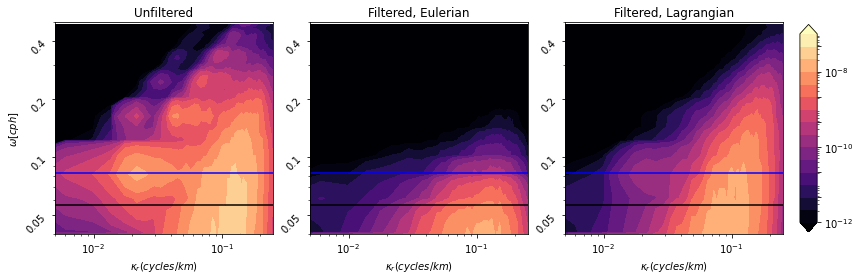

In [117]:
yticks_s = [5*10**-2,10**-1,2*10**-1,4*10**-1]

plt.figure(figsize=(12,4))
omega = ps_iso.freq_time*3600
kr    = ps_iso.kr
lev_exp = np.linspace(-12,-7,16)
lev = np.power(10, lev_exp)
plt.subplot(131)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_zunfilt,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

#for i in range(0,6):
#    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
plt.title('Unfiltered')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(132)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_zeul,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

#for i in range(0,6):
#    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
#plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
plt.title('Filtered, Eulerian')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(133)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_ziso,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)

#for i in range(0,6):
#    plt.plot(kr, omegaM[:,i]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.04, 0.5])
#plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
plt.title('Filtered, Lagrangian')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)



fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax)


fig.savefig('wavenumber_freq_zeta.png')

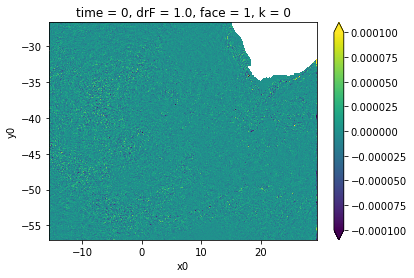

In [123]:
(div_unf-div_filt).isel(time=0).plot(x='x0',vmin=-10**-4,vmax=10**-4)